In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import pickle
import random
from matplotlib import pyplot as plt
from scipy import signal

#Load data

In [4]:
# Load df_positive and df_negative from Google Drive
df_positive = pd.read_pickle('/content/drive/MyDrive/MERMAIDAI/data/df_positive.pkl')
df_negative = pd.read_pickle('/content/drive/MyDrive/MERMAIDAI/data/df_negative.pkl')

In [5]:
for i in range (len(df_positive)):
  df_positive['signal'][i] = df_positive['signal'][i][0]

<ipython-input-5-65f68a070b1b>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_positive['signal'][i] = df_positive['signal'][i][0]
<ipython-input-5-65f68a070b1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [6]:
type(df_positive['signal'][0]), type(df_negative['signal'][0])

(numpy.ndarray, numpy.ndarray)

#Prepare dataset

In [7]:
# create dataset from df_positive and df_negative for training and testing

from sklearn.model_selection import train_test_split

# Combine positive and negative dataframes
df_combined = pd.concat([df_positive, df_negative], ignore_index=True)

# Split the data into training and testing sets
X = df_combined['signal']
y = df_combined['label']


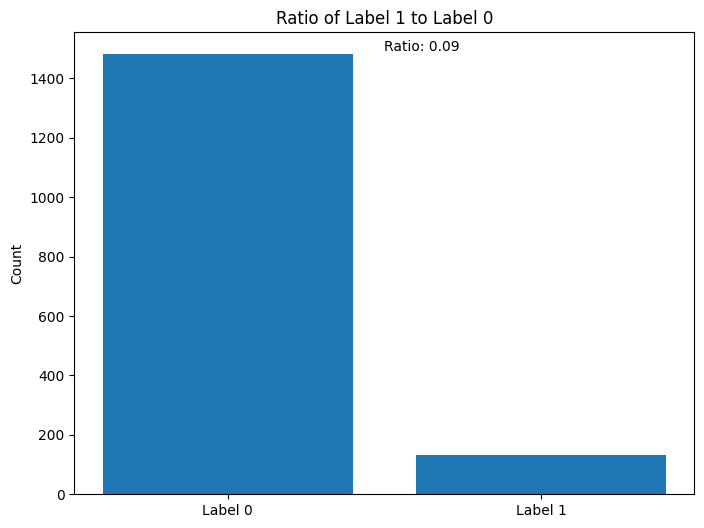

In [8]:
# prompt: plot raito between label 1 and 0

label_counts = y.value_counts()
ratio = label_counts[1] / label_counts[0]

plt.figure(figsize=(8, 6))
plt.bar(['Label 0', 'Label 1'], [label_counts[0], label_counts[1]])
plt.title('Ratio of Label 1 to Label 0')
plt.ylabel('Count')
plt.text(0.5, label_counts[0] + 10, f"Ratio: {ratio:.2f}")

plt.show()

Number of positive samples after augmentation: 1450


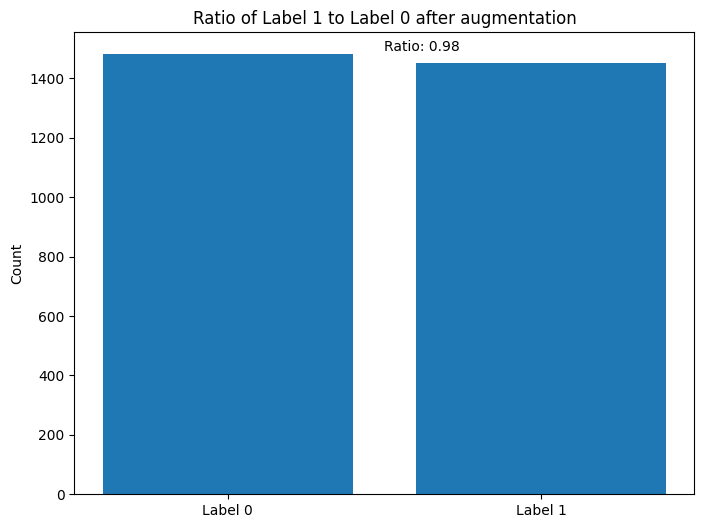

In [9]:
# prompt: augment the data so that label 1 have 1500 samples, by adding random noise


# Augment data for label 1
desired_samples = 1450
current_samples = len(df_positive)
samples_to_add = desired_samples - current_samples


if samples_to_add > 0:
  new_rows = []
  for _ in range(samples_to_add):
    index = random.randint(0, len(df_positive) - 1)
    original_signal = df_positive['signal'][index]
    noise = np.random.normal(0, 0.1, len(original_signal))  # Adjust noise level as needed
    augmented_signal = original_signal + noise
    new_rows.append({'signal': augmented_signal, 'label': 1})

  df_augmented = pd.DataFrame(new_rows)
  df_positive = pd.concat([df_positive, df_augmented], ignore_index=True)

# Verify the number of samples after augmentation
print(f"Number of positive samples after augmentation: {len(df_positive)}")


# Combine positive and negative dataframes after augmentation
df_combined = pd.concat([df_positive, df_negative], ignore_index=True)

# Split the data into training and testing sets after augmentation
X = df_combined['signal']
y = df_combined['label']


label_counts = y.value_counts()
ratio = label_counts[1] / label_counts[0]

plt.figure(figsize=(8, 6))
plt.bar(['Label 0', 'Label 1'], [label_counts[0], label_counts[1]])
plt.title('Ratio of Label 1 to Label 0 after augmentation')
plt.ylabel('Count')
plt.text(0.5, label_counts[0] + 10, f"Ratio: {ratio:.2f}")

plt.show()

In [10]:
X.shape, y.shape

((2931,), (2931,))

In [11]:
X = np.array(X.tolist())
y = np.array(y.tolist())

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2344, 1440), (587, 1440), (2344,), (587,))

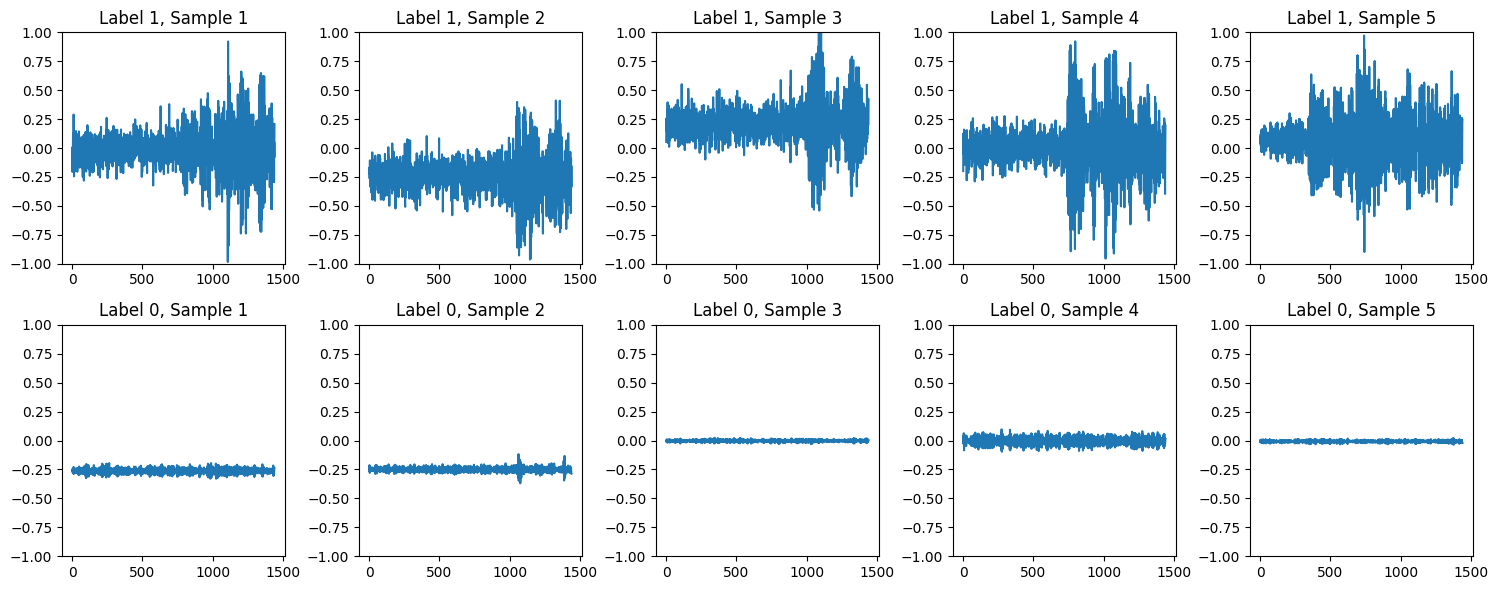

In [14]:
# prompt: plot randomly 5 X_train label 1 and 5 X_train label 0

# Get indices of samples with label 1 and label 0
indices_label_1 = np.where(y_train == 1)[0]
indices_label_0 = np.where(y_train == 0)[0]

# Randomly select 5 samples for each label
random_indices_label_1 = random.sample(list(indices_label_1), 5)
random_indices_label_0 = random.sample(list(indices_label_0), 5)

# Plot the selected samples
plt.figure(figsize=(15, 6))

for i, index in enumerate(random_indices_label_1):
  plt.subplot(2, 5, i + 1)
  plt.plot(X_train[index])
  plt.ylim(-1, 1)
  plt.title(f"Label 1, Sample {i + 1}")

for i, index in enumerate(random_indices_label_0):
  plt.subplot(2, 5, i + 6)
  plt.plot(X_train[index])
  plt.ylim(-1, 1)
  plt.title(f"Label 0, Sample {i + 1}")

plt.tight_layout()
plt.show()

#Training

##Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

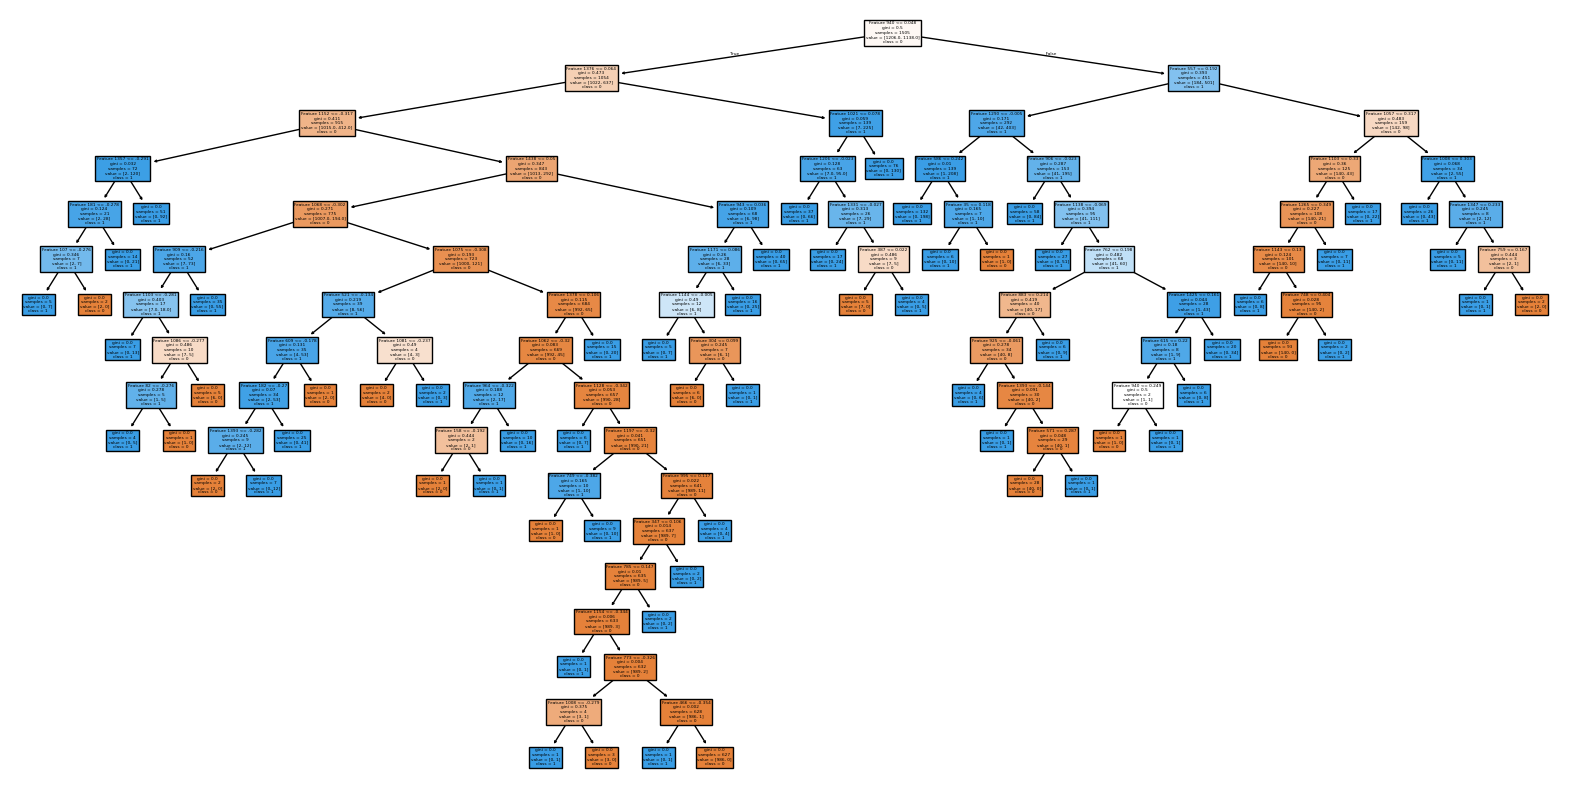

In [17]:
# prompt: Model visualization rfc

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming you have trained your RandomForestClassifier as 'rfc'

# Visualize a single decision tree from the forest
plt.figure(figsize=(20, 10))
plot_tree(rfc.estimators_[0], feature_names=['Feature {}'.format(i) for i in range(X_train.shape[1])], class_names=['0', '1'], filled=True)
plt.show()

# You can visualize more trees by changing the index in rfc.estimators_
# For example, rfc.estimators_[1] for the second tree, etc.

In [18]:
# prompt: model parameter information

#@title Model Parameters
n_estimators = 100 #@param {type:"integer"}
random_state = 42 #@param {type:"integer"}
test_size = 0.2 #@param {type:"number"}


print(f"n_estimators: {n_estimators}")
print(f"random_state: {random_state}")
print(f"test_size: {test_size}")

n_estimators: 100
random_state: 42
test_size: 0.2


In [19]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
y_pred = rfc.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9863713798977853


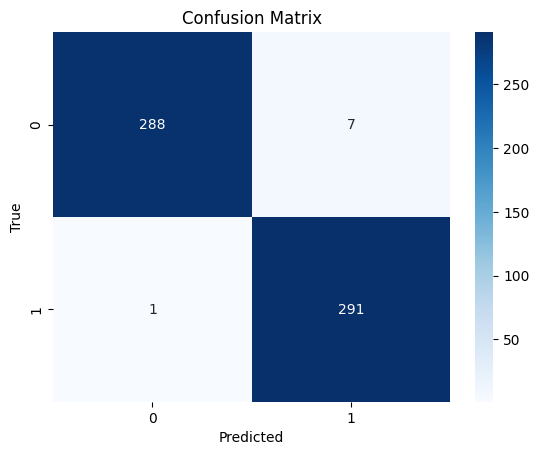

In [20]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have y_test and y_pred from your model's evaluation

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

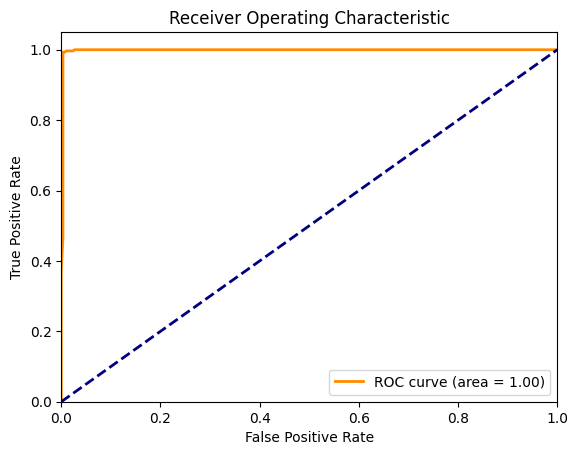

In [21]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rfc.predict_proba(X_test)[:, 1]  # Probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##SVM

In [22]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=100.0, random_state=42)
svc.fit(X_train, y_train)

SVC(C=100.0, random_state=42)

In [ ]:
# prompt: svc model parameter information

# ... (Your existing code)

#@title SVM Model Parameters
kernel = 'rbf' #@param ['linear', 'poly', 'rbf', 'sigmoid']
C = 100.0 #@param {type:"number"}
gamma = 'scale' #@param ['scale', 'auto']
random_state = 42 #@param {type:"integer"}


print(f"kernel: {kernel}")
print(f"C: {C}")
print(f"gamma: {gamma}")
print(f"random_state: {random_state}")

svc = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state, probability=True)
svc.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svc.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Assuming you have y_test and y_pred from your model's evaluation

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_pred_proba = svc.predict_proba(X_test)[:, 1]  # Probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# ... (Rest of your code)

In [24]:
# check overfiting

y_pred_train = svc.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f'Train accuracy: {train_acc}')

y_pred_test = svc.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f'Test accuracy: {test_acc}')

if train_acc > test_acc:
  print('Overfitting')

Train accuracy: 1.0
Test accuracy: 0.9829642248722317
Overfitting


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       295
           1       0.99      0.98      0.98       292

    accuracy                           0.98       587
   macro avg       0.98      0.98      0.98       587
weighted avg       0.98      0.98      0.98       587

Confusion Matrix:
[[292   3]
 [  7 285]]


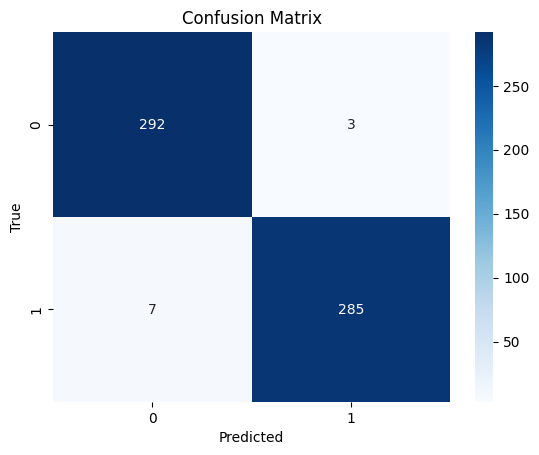

In [25]:
from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred_test))

# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(solver='liblinear')
lrc.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

solver: liblinear
penalty: l2
C: 1.0
max_iter: 100
Accuracy: 0.8926746166950597


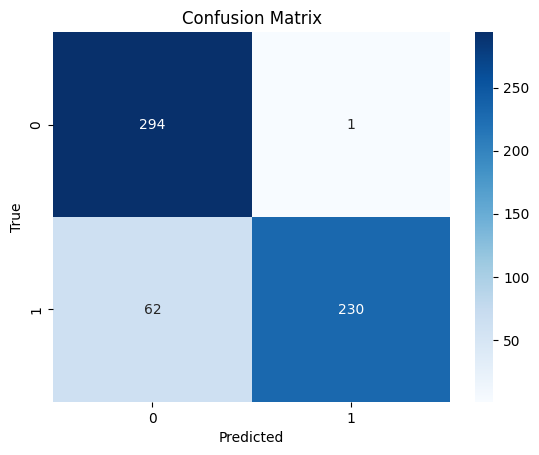

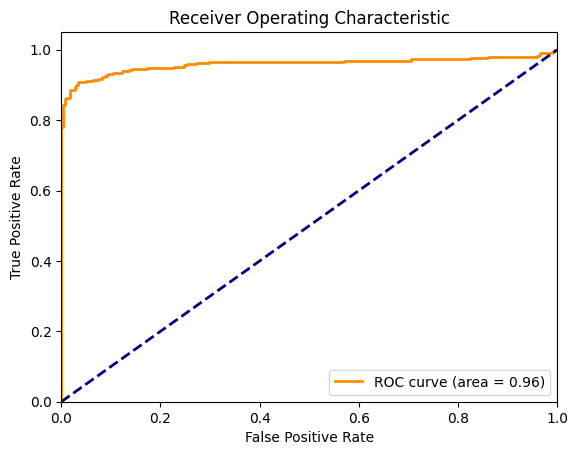

Train accuracy: 0.9940273037542662
Test accuracy: 0.8926746166950597
Overfitting
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       295
           1       1.00      0.79      0.88       292

    accuracy                           0.89       587
   macro avg       0.91      0.89      0.89       587
weighted avg       0.91      0.89      0.89       587

Confusion Matrix:
[[294   1]
 [ 62 230]]


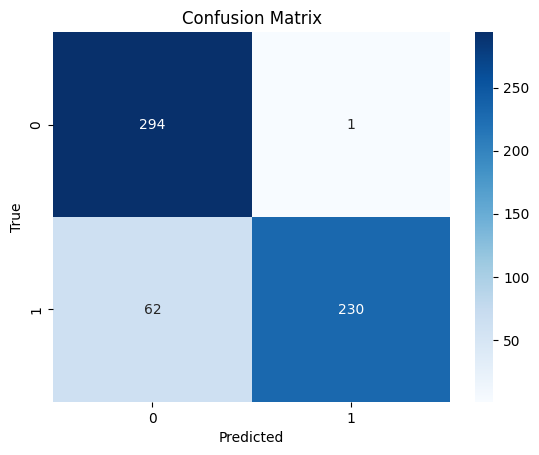

In [28]:
# prompt: lrc model parameter information

#@title Logistic Regression Model Parameters
solver = 'liblinear' #@param ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = 'l2' #@param ['l1', 'l2', 'elasticnet', 'none']
C = 1.0 #@param {type:"number"}
max_iter = 100 #@param {type:"integer"}


print(f"solver: {solver}")
print(f"penalty: {penalty}")
print(f"C: {C}")
print(f"max_iter: {max_iter}")

lrc = LogisticRegression(solver=solver, penalty=penalty, C=C, max_iter=max_iter)
lrc.fit(X_train, y_train)

# ... (Your existing code)


# Make predictions on the test data
y_pred = lrc.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Assuming you have y_test and y_pred from your model's evaluation

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_pred_proba = lrc.predict_proba(X_test)[:, 1]  # Probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# ... (Rest of your code)

# check overfiting

y_pred_train = lrc.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f'Train accuracy: {train_acc}')

y_pred_test = lrc.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f'Test accuracy: {test_acc}')

if train_acc > test_acc:
  print('Overfitting')
# Print classification report
print(classification_report(y_test, y_pred_test))

# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# check overfiting

y_pred_train = lrc.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f'Train accuracy: {train_acc}')

y_pred_test = lrc.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f'Test accuracy: {test_acc}')

if train_acc > test_acc:
  print('Overfitting')

Train accuracy: 0.9940273037542662
Test accuracy: 0.8926746166950597
Overfitting


              precision    recall  f1-score   support

           0       0.86      1.00      0.93       295
           1       1.00      0.84      0.91       292

    accuracy                           0.92       587
   macro avg       0.93      0.92      0.92       587
weighted avg       0.93      0.92      0.92       587

Confusion Matrix:
[[295   0]
 [ 47 245]]


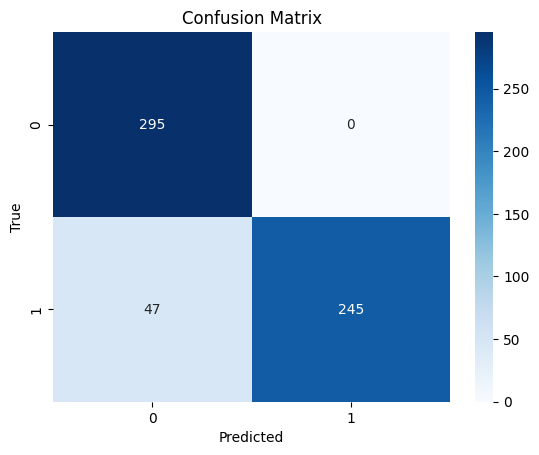

In [ ]:
# Print classification report
print(classification_report(y_test, y_pred_test))

# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##MLP

In [29]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

MLPClassifier()

In [ ]:
# prompt: mlp model parameters infomation

#@title MLP Model Parameters
hidden_layer_sizes = (100,) #@param {type:"raw"}
activation = 'relu' #@param ['identity', 'logistic', 'tanh', 'relu']
solver = 'adam' #@param ['lbfgs', 'sgd', 'adam']
alpha = 0.0001 #@param {type:"number"}
learning_rate = 'constant' #@param ['constant', 'invscaling', 'adaptive']
max_iter = 200 #@param {type:"integer"}


print(f"hidden_layer_sizes: {hidden_layer_sizes}")
print(f"activation: {activation}")
print(f"solver: {solver}")
print(f"alpha: {alpha}")
print(f"learning_rate: {learning_rate}")
print(f"max_iter: {max_iter}")


mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate, max_iter=max_iter)
mlp.fit(X_train, y_train)

# ... (Your existing code)


# Make predictions on the test data
y_pred = mlp.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Assuming you have y_test and y_pred from your model's evaluation

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_pred_proba = mlp.predict_proba(X_test)[:, 1]  # Probability of the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# ... (Rest of your code)

# check overfiting

y_pred_train = mlp.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f'Train accuracy: {train_acc}')

y_pred_test = mlp.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f'Test accuracy: {test_acc}')

if train_acc > test_acc:
  print('Overfitting')
# Print classification report
print(classification_report(y_test, y_pred_test))

# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# check overfiting

y_pred_train = mlp.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f'Train accuracy: {train_acc}')

y_pred_test = mlp.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f'Test accuracy: {test_acc}')

if train_acc > test_acc:
  print('Overfitting')

Train accuracy: 1.0
Test accuracy: 0.9846678023850085
Overfitting


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       295
           1       1.00      0.97      0.98       292

    accuracy                           0.98       587
   macro avg       0.99      0.98      0.98       587
weighted avg       0.98      0.98      0.98       587

Confusion Matrix:
[[294   1]
 [  8 284]]


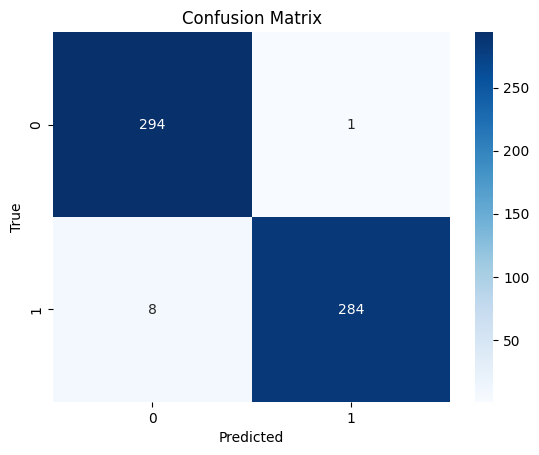

In [31]:
# Print classification report
print(classification_report(y_test, y_pred_test))

# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##LSTM

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [39]:
# Reshape the input data for LSTM (samples, time steps, features)
timesteps = X_train[0].shape[0]  # Assuming all signals have the same length
# Use a list comprehension to reshape each signal individually, ensuring uniform length
X_train_lstm = np.array([signal.reshape(-1, 1) for signal in X_train if signal.shape[0] == timesteps])
X_test_lstm = np.array([signal.reshape(-1, 1) for signal in X_test if signal.shape[0] == timesteps])
# Filter the corresponding labels to match the filtered signals
# Use boolean indexing instead of apply for NumPy arrays
y_train_lstm = y_train[[signal.shape[0] == timesteps for signal in X_train]]
y_test_lstm = y_test[[signal.shape[0] == timesteps for signal in X_test]]

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.7046 - loss: 0.5450 - val_accuracy: 0.5026 - val_loss: 0.6963
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.4994 - loss: 0.6954 - val_accuracy: 0.5026 - val_loss: 0.6945
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.4996 - loss: 0.6940 - val_accuracy: 0.5026 - val_loss: 0.6935
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.4961 - loss: 0.6932 - val_accuracy: 0.5026 - val_loss: 0.6932
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.4877 - loss: 0.6951 - val_accuracy: 0.5026 - val_loss: 0.6946
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5020 - loss: 0.6941 - val_accuracy: 0.4974 - val_loss: 0.6974
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.4824 - loss: 0.6983 - val_accuracy: 0.5043 - val_loss: 0.6929
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5017 - loss: 0.6936 - val_accuracy: 0.502

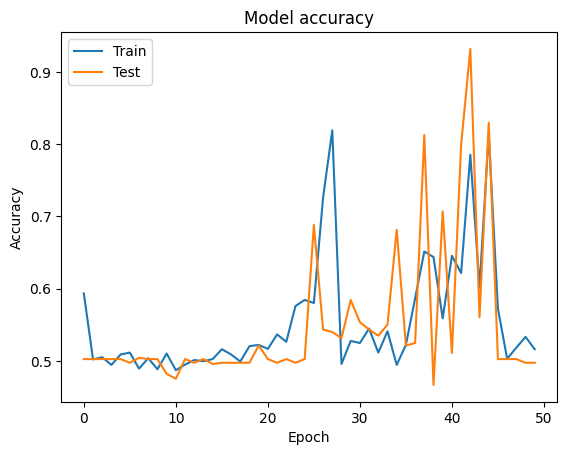

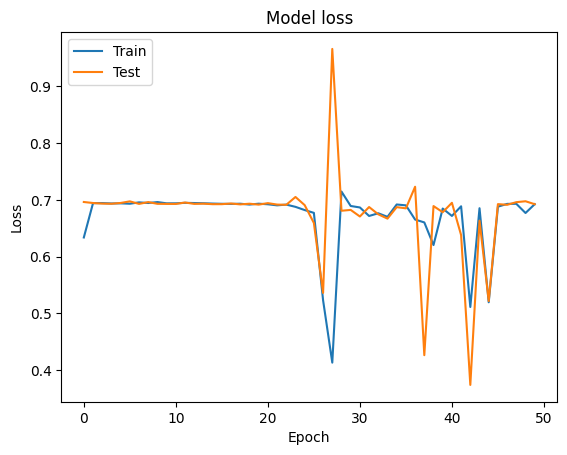

In [ ]:
# train model and plot training and validation process
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, 1)))  # Adjust the number of LSTM units
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.5126 - loss: 0.6940 - val_accuracy: 0.4855 - val_loss: 0.6935
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.5419 - loss: 0.6910 - val_accuracy: 0.5298 - val_loss: 0.9915
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.5369 - loss: 0.7252 - val_accuracy: 0.5026 - val_loss: 0.6932
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.4875 - loss: 0.6951 - val_accuracy: 0.5026 - val_loss: 0.6932
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.5186 - loss: 0.6935 - val_accuracy: 0.5026 - val_loss: 0.6956
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.5070 - loss: 0.6949 - val_accuracy: 0.4974 - val_loss: 0.6935
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - accuracy: 0.5171 - loss: 0.6934 - val_accuracy: 0.5077 - val_loss: 0.6930
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.5012 - loss: 0.6938 - val_accu

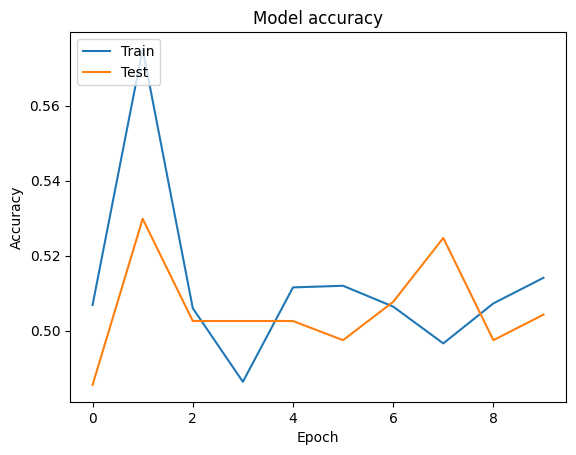

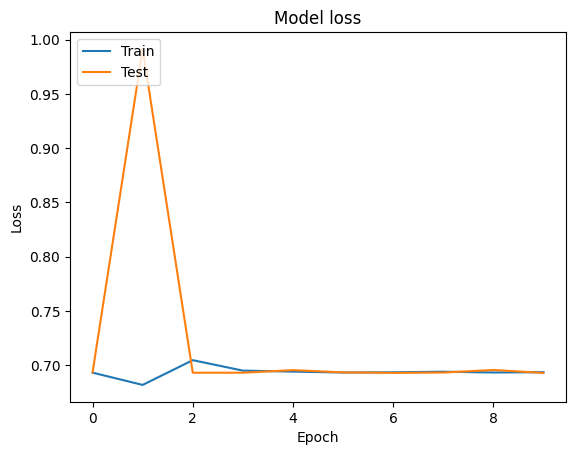

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

# Build the LSTM model with Bidirectional layers
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - accuracy: 0.5152 - loss: 0.6930 - val_accuracy: 0.4889 - val_loss: 0.6928
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.4793 - loss: 0.6937 - val_accuracy: 0.4872 - val_loss: 0.6925
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.4986 - loss: 0.6926 - val_accuracy: 0.6746 - val_loss: 0.6912
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.6101 - loss: 0.6894 - val_accuracy: 0.6031 - val_loss: 0.6738
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.5881 - loss: 0.7228 - val_accuracy: 0.4787 - val_loss: 0.6930
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.5226 - loss: 0.6920 - val_accuracy: 0.5468 - val_loss: 0.6907
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5947 - loss: 0.6880 - val_accuracy: 0.5264 - val_loss: 0.6811
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.5978 - loss: 0.6626 - val_accurac

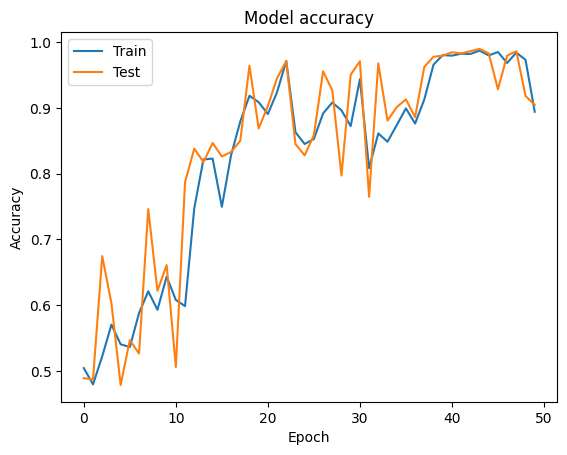

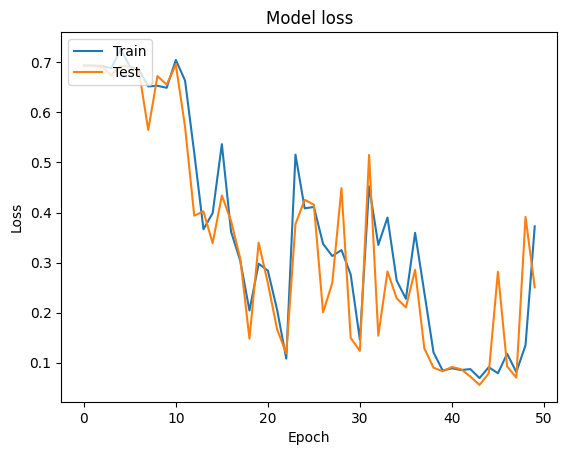

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

# Build the LSTM model with Bidirectional layers
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.4962 - loss: 0.6938 - val_accuracy: 0.5503 - val_loss: 0.6929
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.5426 - loss: 0.6929 - val_accuracy: 0.4872 - val_loss: 0.6920
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.5659 - loss: 0.6931 - val_accuracy: 0.5094 - val_loss: 0.6880
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.5245 - loss: 0.6903 - val_accuracy: 0.5332 - val_loss: 0.6911
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.5594 - loss: 0.6902 - val_accuracy: 0.5503 - val_loss: 0.6876
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.5820 - loss: 0.6761 - val_accuracy: 0.6559 - val_loss: 0.6271
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.5914 - loss: 0.6738 - val_accuracy: 0.7785 - val_loss: 0.6332
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.6571 - loss: 0.6425 - va

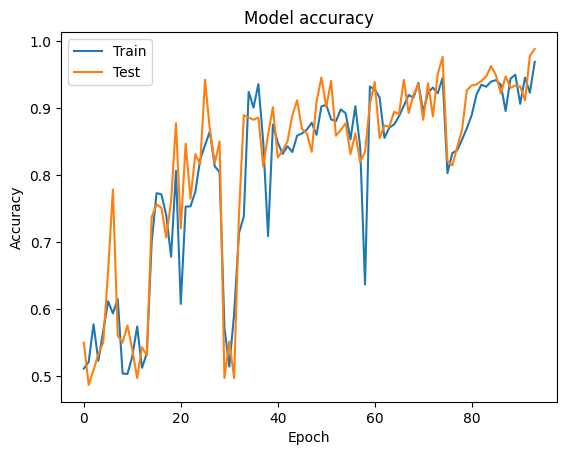

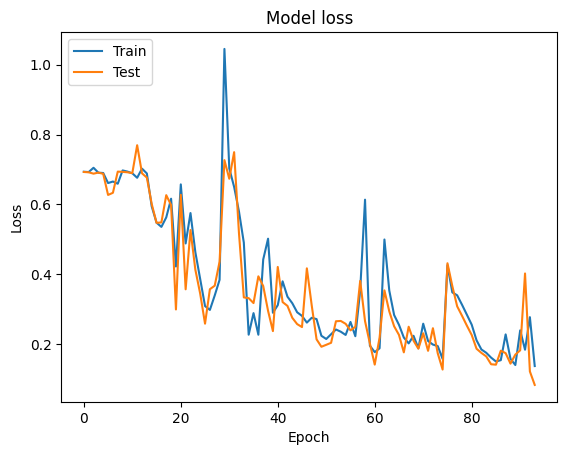

In [ ]:
# prompt: train LSTM with stopping when achive max accuracy

# Build the LSTM model with Bidirectional layers
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))  # Add dropout layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Define a callback to stop training when max accuracy is reached
class MaxAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_accuracy=0.98):
        super(MaxAccuracyCallback, self).__init__()
        self.max_accuracy = max_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.max_accuracy:
            print(f"\nReached max accuracy of {self.max_accuracy}. Stopping training.")
            self.model.stop_training = True


# Train the model with the callback
history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[MaxAccuracyCallback()])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# prompt: save model for continue training

# Save the trained model for later use
model.save('/content/drive/MyDrive/MERMAIDAI/models/lstm_model.h5')

In [35]:
import tensorflow as tf
# Load the saved model (optional, for later use)
LSTM_model = tf.keras.models.load_model('/content/drive/MyDrive/MERMAIDAI/models/lstm_model.h5')

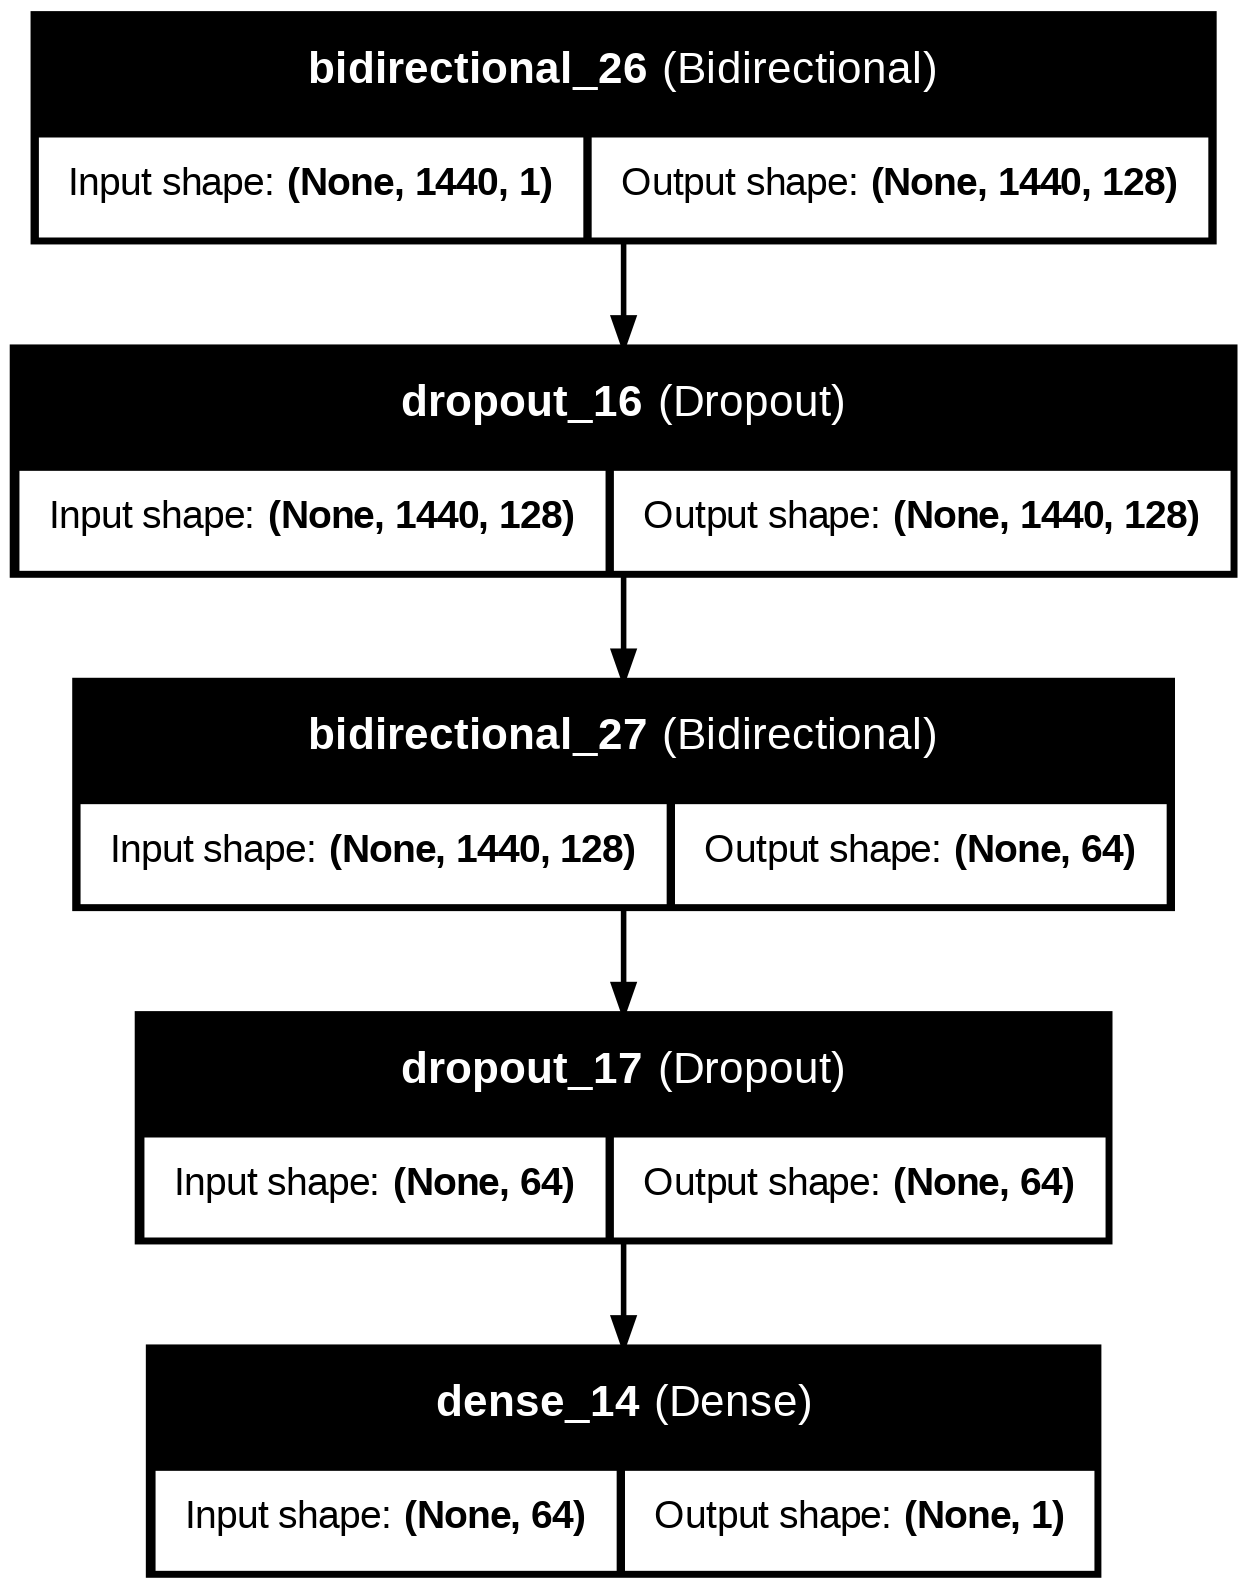

In [37]:
# prompt: plot LSTM_model visualization

from tensorflow.keras.utils import plot_model

# Assuming 'model' is your trained LSTM model
plot_model(LSTM_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

# Display the generated plot in Colab
from IPython.display import Image
Image('lstm_model.png')

In [ ]:
# prompt: LSTM_model parameter information

#@title LSTM Model Parameters
lstm_units = 50  #@param {type:"integer"}
dense_units = 1  #@param {type:"integer"}
epochs = 50  #@param {type:"integer"}
batch_size = 32  #@param {type:"integer"}


print(f"lstm_units: {lstm_units}")
print(f"dense_units: {dense_units}")
print(f"epochs: {epochs}")
print(f"batch_size: {batch_size}")

# ... (Your existing code)

# Define the LSTM model
model = Sequential()
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(timesteps, 1)))
model.add(LSTM(lstm_units))
model.add(Dense(dense_units, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
history = model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test_lstm, y_test_lstm))

# ... (Rest of your code)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9912 - loss: 0.0736
Test Loss: 0.08293410390615463
Test Accuracy: 0.9880749583244324
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
Confusion Matrix:
[[291   4]
 [  3 289]]


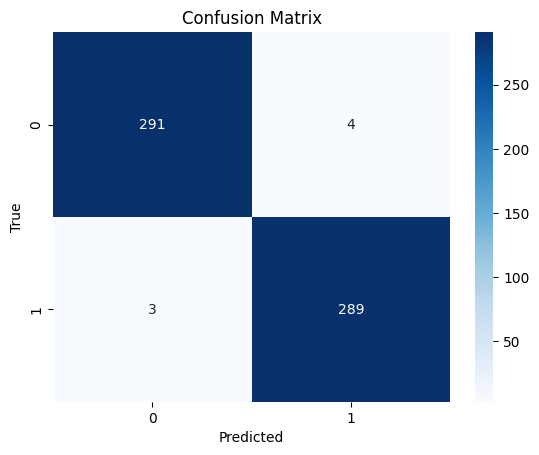

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       295
           1       0.99      0.99      0.99       292

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


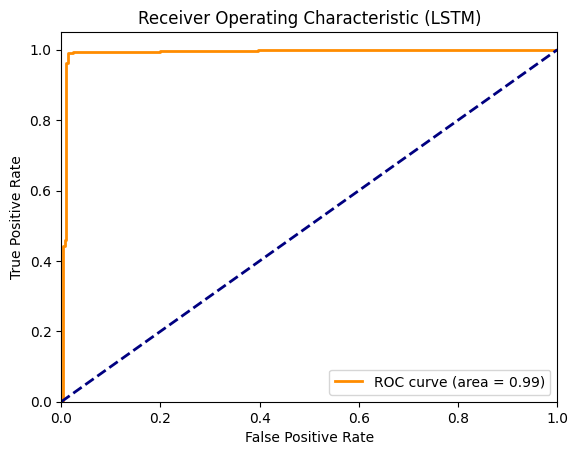

In [40]:
# prompt: evaluation model  LSTM

# Evaluate the LSTM model
loss, accuracy = LSTM_model.evaluate(X_test_lstm, y_test_lstm)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test data
y_pred_lstm = (LSTM_model.predict(X_test_lstm) > 0.5).astype("int32")

# Generate and print confusion matrix
cm = confusion_matrix(y_test_lstm, y_pred_lstm)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test_lstm, y_pred_lstm))

# Calculate ROC AUC
y_pred_proba_lstm = LSTM_model.predict(X_test_lstm)
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test_lstm, y_pred_proba_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (LSTM)')
plt.legend(loc="lower right")
plt.show()

In [41]:
# prompt: Plot training & validation accuracy values

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

##LSTM with attention

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.4834 - loss: 0.6937 - val_accuracy: 0.4685 - val_loss: 0.6931
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.4994 - loss: 0.6933 - val_accuracy: 0.5417 - val_loss: 0.6927
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5077 - loss: 0.6932 - val_accuracy: 0.5060 - val_loss: 0.6925
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5321 - loss: 0.6922 - val_accuracy: 0.5707 - val_loss: 0.6912
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6395 - loss: 0.6864 - val_accuracy: 0.7700 - val_loss: 0.6398
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7502 - loss: 0.6658 - val_accuracy: 0.9319 - val_loss: 0.5150
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9157 - loss: 0.4442 - val_accuracy: 0.9796 - val_loss: 0.2646
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9247 - loss: 0.2339 - val_accurac

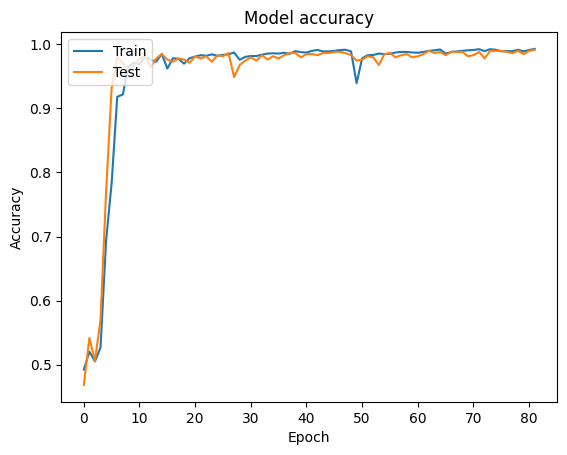

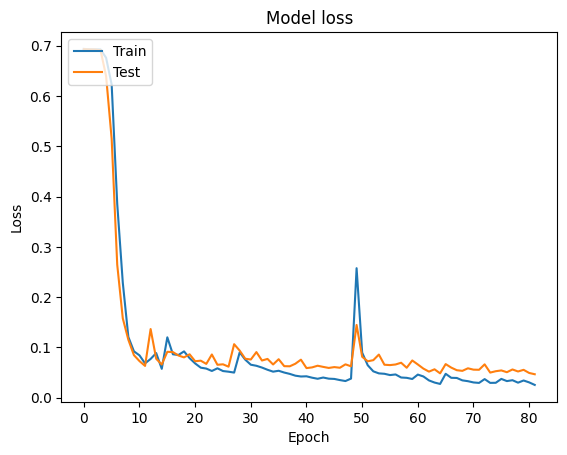

In [47]:
# prompt: train with LSTM with attention layer

from tensorflow.keras.layers import Layer, Input, Embedding, LSTM, Dense, Attention, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Define the attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[-1], input_shape[-1])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[-1], 1)),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.tensordot(x, self.W_a, axes=1)
        et = tf.nn.tanh(et)
        at = tf.tensordot(et, self.U_a, axes=1)
        at = tf.nn.softmax(at, axis=1)
        output = x * at
        return tf.reduce_sum(output, axis=1)

# Build the LSTM model with attention
inputs = Input(shape=(X_train.shape[1], 1))
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)
attention_out = AttentionLayer()(lstm_out)
output = Dense(1, activation='sigmoid')(attention_out)

model_attention = Model(inputs=inputs, outputs=output)

# Compile the model
model_attention.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


# Define a callback to stop training when max accuracy is reached
class MaxAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_accuracy=0.99):
        super(MaxAccuracyCallback, self).__init__()
        self.max_accuracy = max_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.max_accuracy:
            print(f"\nReached max accuracy of {self.max_accuracy}. Stopping training.")
            self.model.stop_training = True


# Train the model with the callback
history = model_attention.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[MaxAccuracyCallback()])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [46]:
model_attention = tf.keras.models.load_model('/content/drive/MyDrive/MERMAIDAI/models/lstm_attention_model.h5')

ValueError: Unknown layer: 'AttentionLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9942 - loss: 0.0291
Test Loss: 0.04648460075259209
Test Accuracy: 0.991482138633728
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Confusion Matrix:
[[290   5]
 [  0 292]]


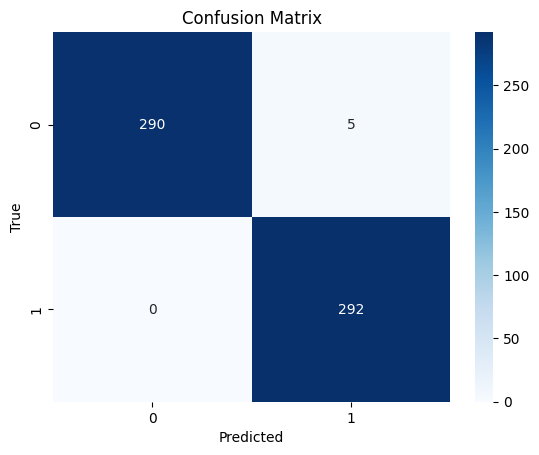

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       295
           1       0.98      1.00      0.99       292

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


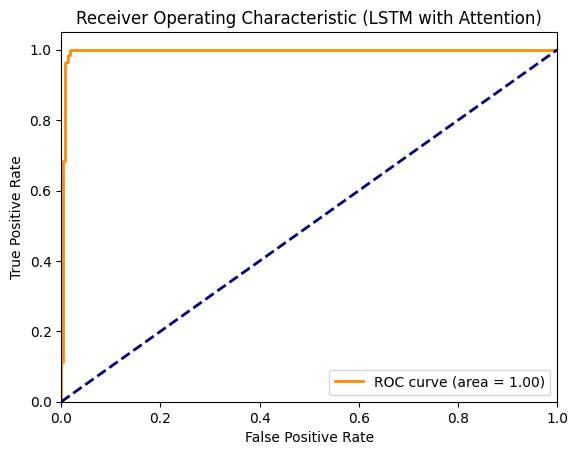

In [49]:
# Evaluate the LSTM model with attention
loss, accuracy = model_attention.evaluate(X_test_lstm, y_test_lstm)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test data
y_pred_lstm_attention = (model_attention.predict(X_test_lstm) > 0.5).astype("int32")

# Generate and print confusion matrix
cm = confusion_matrix(y_test_lstm, y_pred_lstm_attention)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test_lstm, y_pred_lstm_attention))

# Calculate ROC AUC
y_pred_proba_lstm_attention = model_attention.predict(X_test_lstm)
fpr_lstm_attention, tpr_lstm_attention, thresholds_lstm_attention = roc_curve(y_test_lstm, y_pred_proba_lstm_attention)
roc_auc_lstm_attention = auc(fpr_lstm_attention, tpr_lstm_attention)

plt.figure()
plt.plot(fpr_lstm_attention, tpr_lstm_attention, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lstm_attention)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (LSTM with Attention)')
plt.legend(loc="lower right")
plt.show()

In [51]:
# prompt: Which samples were mislabeled by model_attention?

# Find indices where the model's prediction differs from the true label
mislabeled_indices = [i for i, (true_label, pred_label) in enumerate(zip(y_test_lstm, y_pred_lstm_attention)) if true_label != pred_label]

# Print the samples that were mislabeled
print("Mislabeled samples:")
for i in mislabeled_indices:
  print(f"Sample index: {i}, True label: {y_test_lstm[i]}, Predicted label: {y_pred_lstm_attention[i]}")


Mislabeled samples:
Sample index: 123, True label: 0, Predicted label: [1]
Sample index: 298, True label: 0, Predicted label: [1]
Sample index: 304, True label: 0, Predicted label: [1]
Sample index: 519, True label: 0, Predicted label: [1]
Sample index: 549, True label: 0, Predicted label: [1]


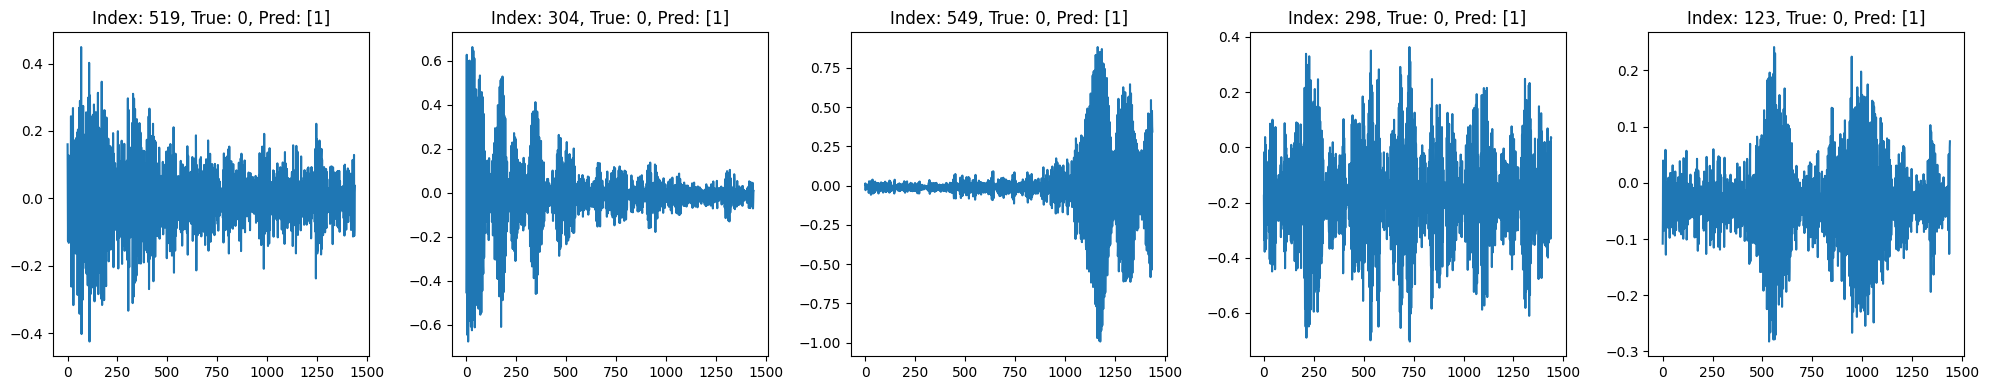

In [53]:
# prompt: plot 5 mislabeled by model_attention in one row

import matplotlib.pyplot as plt

# Assuming X_test_lstm and y_test_lstm are your test data and labels

# Find indices where the model's prediction differs from the true label
mislabeled_indices = [i for i, (true_label, pred_label) in enumerate(zip(y_test_lstm, y_pred_lstm_attention)) if true_label != pred_label]

# Select 5 random mislabeled indices
num_plots = 5
if len(mislabeled_indices) >= num_plots:
  selected_indices = random.sample(mislabeled_indices, num_plots)
else:
  selected_indices = mislabeled_indices

# Plot the selected mislabeled samples in one row
plt.figure(figsize=(20, 4))
for i, index in enumerate(selected_indices):
  plt.subplot(1, num_plots, i + 1)
  plt.plot(X_test_lstm[index])
  plt.title(f"Index: {index}, True: {y_test_lstm[index]}, Pred: {y_pred_lstm_attention[index]}")
plt.tight_layout()
plt.show()

In [ ]:
# prompt: save model_attention

# Save the trained model for later use
model_attention.save('/content/drive/MyDrive/MERMAIDAI/models/lstm_attention_model.h5')

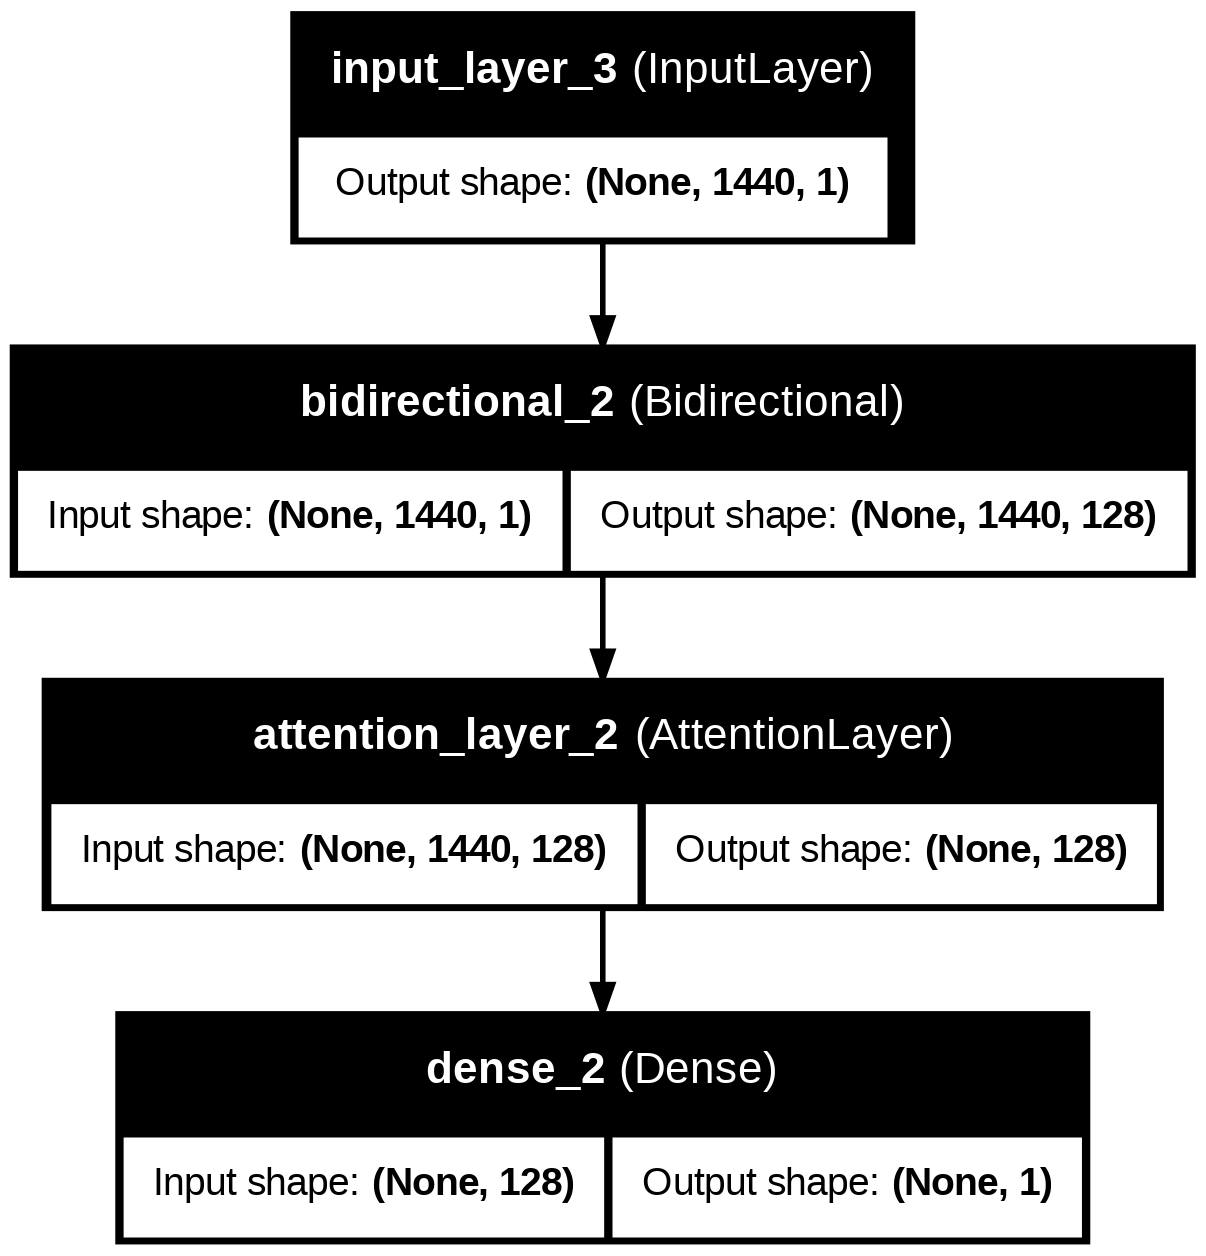

In [48]:
# prompt: plot model_attention visualization

from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Assuming 'model_attention' is your trained LSTM with attention model
plot_model(model_attention, to_file='lstm_attention_model.png', show_shapes=True, show_layer_names=True)

# Display the generated plot in Colab
Image('lstm_attention_model.png')

##CNN

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7849 - loss: 0.3791 - val_accuracy: 0.9830 - val_loss: 0.0831
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9904 - loss: 0.0504 - val_accuracy: 0.9881 - val_loss: 0.0653
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9909 - loss: 0.0465 - val_accuracy: 0.9898 - val_loss: 0.0654
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9931 - loss: 0.0291 - val_accuracy: 0.9932 - val_loss: 0.0626
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9924 - loss: 0.0272 - val_accuracy: 0.9932 - val_loss: 0.0732
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9948 - loss: 0.0210 - val_accuracy: 0.9864 - val_loss: 0.0751
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9957 - loss: 0.0206 - val_accuracy: 0.9932 - val_loss: 0.0781
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9980 - loss: 0.0109 - val_accuracy: 0.9949 - val_loss: 0.0868
Ep

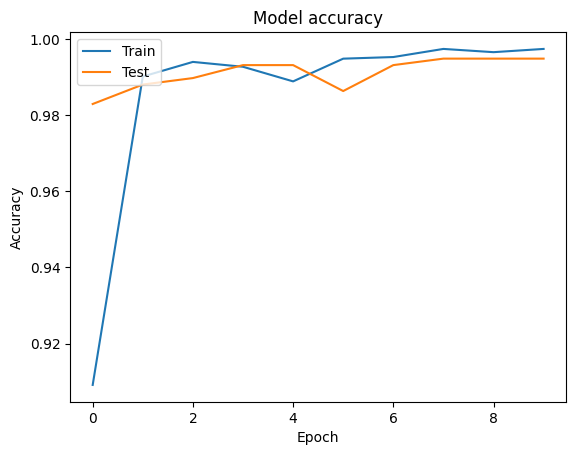

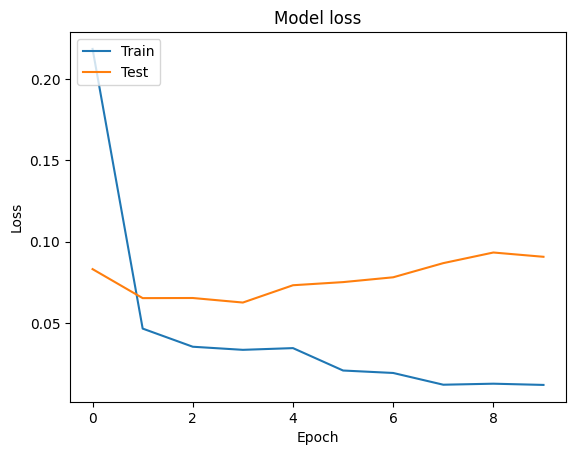

In [ ]:
# prompt: train with CNN -1d model

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Reshape the input data for CNN (samples, time steps, features)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN model
history = model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# prompt: save cnn

# Save the trained CNN model
model.save('/content/drive/MyDrive/MERMAIDAI/models/cnn_model.h5')

In [ ]:
# Load the saved model (optional, for later use)
CNN_model = tf.keras.models.load_model('/content/drive/MyDrive/MERMAIDAI/models/cnn_model.h5')

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9970 - loss: 0.0236
Test Loss: 0.09071914851665497
Test Accuracy: 0.9948892593383789
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Confusion Matrix:
[[293   2]
 [  1 291]]


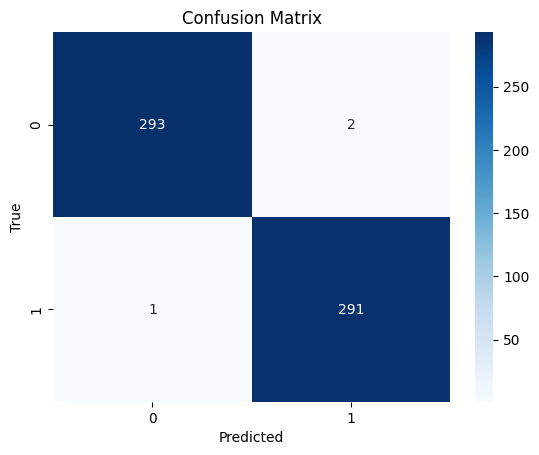

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       295
           1       0.99      1.00      0.99       292

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


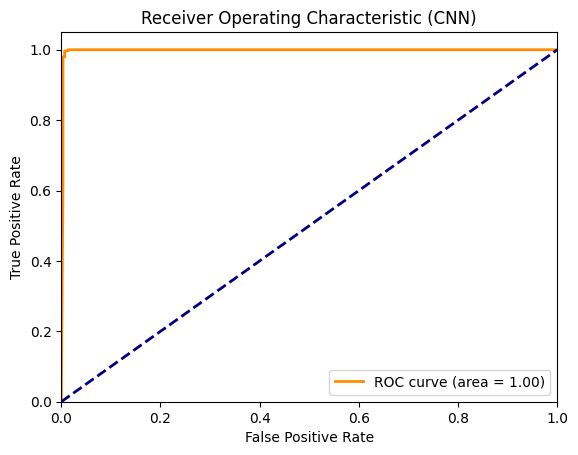

In [ ]:
# Evaluate the CNN model
loss, accuracy = CNN_model.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test data
y_pred_cnn = (CNN_model.predict(X_test_cnn) > 0.5).astype("int32")

# Generate and print confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_cnn))

# Calculate ROC AUC
y_pred_proba_cnn = CNN_model.predict(X_test_cnn)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_proba_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (CNN)')
plt.legend(loc="lower right")
plt.show()